In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk 
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
import pickle

In [2]:
df_true = pd.read_csv('True.csv')

In [3]:
df_true.head(5)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
df_true.shape

(21417, 4)

In [5]:
df_fake = pd.read_csv('Fake.csv')

In [6]:
df_fake.head(5)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
df_fake.shape

(23481, 4)

# Data Cleaning

In [8]:
df_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [9]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


Since we will be basing our model on text data, out column are not relevant to our model; therefor all other columns will be drop except "text".

In [10]:
df_fake =  df_fake.drop_duplicates() #dropping duplicated values

In [11]:
df_fake = df_fake.dropna() #dropping nan values

In [12]:
df_true = df_true.dropna() #dropping nan values

In [13]:
df_fake.info() #checking to see if nan values are dropped 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23478 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23478 non-null  object
 1   text     23478 non-null  object
 2   subject  23478 non-null  object
 3   date     23478 non-null  object
dtypes: object(4)
memory usage: 917.1+ KB


In [14]:
df_true.info() #checking to see if nan values are dropped

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [15]:
df_fake = df_fake.drop(columns=['title', 'subject', 'date']) #dropping unused variables

In [16]:
df_fake.sample(5) #sampling the dataset

,text
3126,"Unless you ve been living under a rock, you ar..."
7804,Republican front runner Donald Trump refused t...
2841,"Seriously. Apparently, he thought being presid..."
19976,OUCH! Trump really put things in perspective w...
1347,In a stunning example of just how morally bank...


In [17]:
df_true = df_true.drop(columns=['title', 'date','subject'])

In [18]:
df_true.sample()

,text
14020,BERLIN (Reuters) - The leader of Germany s Soc...


We will add a new column that will either be 0 or 1 based on if the news is fake or real. Fake news will be given 0 and real news will be given 1. 

In [19]:
df_fake['Target'] = 0 #adding target column to the dataset

In [20]:
df_fake.sample(5) #sampling the data

,text,Target
23014,21st Century Wire says A group of top Silicon ...,0
9810,John McCain really doesn t care what topic rep...,0
269,Like increasing numbers of heartless people on...,0
10043,Rebel Pundit decided to follow a local activis...,0
16124,President Trump s 2017 Tax Reform for Economi...,0


In [21]:
df_true['Target'] = 1 #adding target column to the data

In [22]:
df_true.sample(5) #sample of the dataset aftering adding "Target" column

,text,Target
4393,ISTANBUL (Reuters) - Turkey’s foreign minister...,1
272,NEW YORK (LPC/IFR) - U.S. regulators said they...,1
11,NEW YORK/WASHINGTON (Reuters) - The new U.S. t...,1
77,WASHINGTON (Reuters) - Eight months into his l...,1
6564,WASHINGTON (Reuters) - President-elect Donald ...,1


Now we will concat both dataset into metadata

In [23]:
data = pd.concat([df_fake, df_true]) #concat the two dataset

In [24]:
data.sample(5) #sample of the dataset

,text,Target
9461,Infowars uncovered a bombshell when they disco...,0
6156,When Donald Trump recently said he would love ...,0
2087,The following statements were posted to the ve...,1
2972,NEW YORK (Reuters) - The now-delayed U.S. Sena...,1
19318,One of our biggest concerns is that so many Am...,0


# EDA

In [25]:
data

,text,Target
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0
...,...,...
21412,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
21413,"LONDON (Reuters) - LexisNexis, a provider of l...",1
21414,MINSK (Reuters) - In the shadow of disused Sov...,1
21415,MOSCOW (Reuters) - Vatican Secretary of State ...,1


In [26]:
data['Target'].value_counts() 

0    23478
1    21417
Name: Target, dtype: int64

([<matplotlib.patches.Wedge at 0x7f8eb7948df0>,
 [Text(-0.07925311595859819, 1.09714125964292, 'Real'),
  Text(0.07925311595859781, -1.09714125964292, 'Fake')],
 [Text(-0.04322897234105355, 0.5984406870779563, '52.30'),
  Text(0.04322897234105334, -0.5984406870779563, '47.70')])

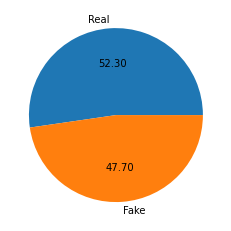

In [27]:
plt.pie(data['Target'].value_counts(), labels=['Real', 'Fake'], autopct="%0.2f") #pie plot of the data

Observation : The data tells us that is a slight imbalance in the data. There is more data that is real than fake news. 

In [28]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/jawadkhattak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
data['NumberOfCharacters'] = data['text'].apply(len) #Finding length of each text

In [30]:
data.sample(5) #sampling the data to see if the new variable is added

,text,Target,NumberOfCharacters
4718,After GOP candidate Donald Trump and Democrati...,0,2011
11265,WASHINGTON (Reuters) - U.S. Vice President Joe...,1,3250
7000,BEIJING (Reuters) - China said on Wednesday it...,1,1190
19299,Young black man delivers poignant message to ...,0,1302
23097,Syrian Army soldier holds up Al Nusra Front (...,0,9265


In [31]:
data.describe() #checking to see how our data look

,Target,NumberOfCharacters
count,44895.000000,44895.000000
mean,0.477046,2469.187950
std,0.499478,2171.663707
min,0.000000,1.000000
25%,0.000000,1234.000000
50%,0.000000,2186.000000
75%,1.000000,3105.500000
max,1.000000,51794.000000


The statistical analysis of the dataframe shows that there is/are text that has only one word. This won't help us our modle so we will drop text that length of 1. 

In [32]:
data[data['text'].str.len() <= 1]

,text,Target,NumberOfCharacters
10923,,0,1
11041,,0,1
11190,,0,1
11225,,0,1
11236,,0,1
...,...,...,...
21826,,0,1
21827,,0,1
21857,,0,1
21873,,0,1


In [33]:
data[data['text'].str.len() <= 5]['text'].value_counts()

         627
           4
Ouch!      2
Name: text, dtype: int64

We will drop these text because they are too small to test our model upon. 

In [34]:
data.shape

(44895, 3)

In [35]:
data

,text,Target,NumberOfCharacters
0,Donald Trump just couldn t wish all Americans ...,0,2893
1,House Intelligence Committee Chairman Devin Nu...,0,1898
2,"On Friday, it was revealed that former Milwauk...",0,3597
3,"On Christmas day, Donald Trump announced that ...",0,2774
4,Pope Francis used his annual Christmas Day mes...,0,2346
...,...,...,...
21412,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1,2821
21413,"LONDON (Reuters) - LexisNexis, a provider of l...",1,800
21414,MINSK (Reuters) - In the shadow of disused Sov...,1,1950
21415,MOSCOW (Reuters) - Vatican Secretary of State ...,1,1199


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44895 entries, 0 to 21416
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   text                44895 non-null  object
 1   Target              44895 non-null  int64 
 2   NumberOfCharacters  44895 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


In [37]:
data[data['text'].str.strip().str.len() >= 1]

,text,Target,NumberOfCharacters
0,Donald Trump just couldn t wish all Americans ...,0,2893
1,House Intelligence Committee Chairman Devin Nu...,0,1898
2,"On Friday, it was revealed that former Milwauk...",0,3597
3,"On Christmas day, Donald Trump announced that ...",0,2774
4,Pope Francis used his annual Christmas Day mes...,0,2346
...,...,...,...
21412,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1,2821
21413,"LONDON (Reuters) - LexisNexis, a provider of l...",1,800
21414,MINSK (Reuters) - In the shadow of disused Sov...,1,1950
21415,MOSCOW (Reuters) - Vatican Secretary of State ...,1,1199


In [38]:
data['NumberOfWords'] = data['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [39]:
data['NumberOfSentences'] = data['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [40]:
data.head()

,text,Target,NumberOfCharacters,NumberOfWords,NumberOfSentences
0,Donald Trump just couldn t wish all Americans ...,0,2893,599,28
1,House Intelligence Committee Chairman Devin Nu...,0,1898,331,11
2,"On Friday, it was revealed that former Milwauk...",0,3597,689,25
3,"On Christmas day, Donald Trump announced that ...",0,2774,519,15
4,Pope Francis used his annual Christmas Day mes...,0,2346,458,19


In [41]:
data[['NumberOfCharacters', 'NumberOfWords', 'NumberOfSentences']].describe()

,NumberOfCharacters,NumberOfWords,NumberOfSentences
count,44895.000000,44895.000000,44895.000000
mean,2469.187950,453.459828,14.872079
std,2171.663707,394.785857,12.694070
min,1.000000,0.000000,0.000000
25%,1234.000000,226.000000,7.000000
50%,2186.000000,403.000000,13.000000
75%,3105.500000,572.000000,19.000000
max,51794.000000,9958.000000,321.000000


In [42]:
data['NumberOfSentences'].describe()

count    44895.000000
mean        14.872079
std         12.694070
min          0.000000
25%          7.000000
50%         13.000000
75%         19.000000
max        321.000000
Name: NumberOfSentences, dtype: float64

In [43]:
#Fake News
data[data['Target'] ==0][['NumberOfCharacters', 'NumberOfWords', 'NumberOfSentences']].describe()

,NumberOfCharacters,NumberOfWords,NumberOfSentences
count,23478.000000,23478.000000,23478.000000
mean,2547.555882,470.067553,14.920010
std,2532.998914,457.175413,13.793084
min,1.000000,0.000000,0.000000
25%,1433.000000,266.000000,7.000000
50%,2166.000000,403.000000,13.000000
75%,3032.000000,562.000000,19.000000
max,51794.000000,9958.000000,288.000000


In [44]:
#Real News
data[data['Target'] ==1][['NumberOfCharacters', 'NumberOfWords', 'NumberOfSentences']].describe()

,NumberOfCharacters,NumberOfWords,NumberOfSentences
count,21417.000000,21417.00000,21417.000000
mean,2383.278517,435.25391,14.819536
std,1684.835730,311.38484,11.367958
min,1.000000,0.00000,0.000000
25%,914.000000,168.00000,6.000000
50%,2222.000000,404.00000,13.000000
75%,3237.000000,589.00000,20.000000
max,29781.000000,5979.00000,321.000000


/tmp/ipykernel_11251/4094327692.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data[data['Target']==0]['NumberOfCharacters'], kde=True, multiple="stack", palette="husl")
/tmp/ipykernel_11251/4094327692.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data[data['Target']==1]['NumberOfCharacters'], color = 'red', kde=True, multiple="stack", palette="husl")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


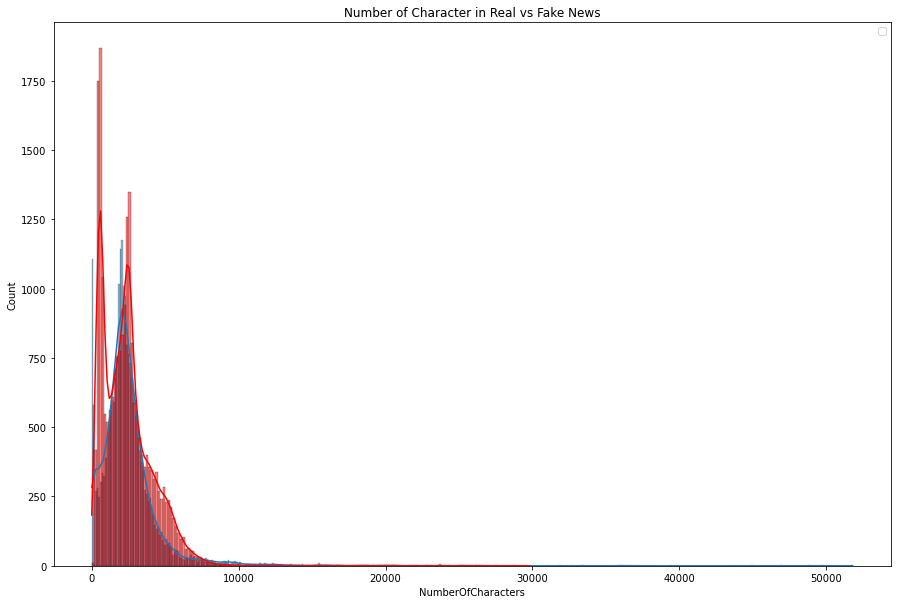

In [45]:
plt.figure(figsize=(15,10))
sns.histplot(data[data['Target']==0]['NumberOfCharacters'], kde=True, multiple="stack", palette="husl")
sns.histplot(data[data['Target']==1]['NumberOfCharacters'], color = 'red', kde=True, multiple="stack", palette="husl")
plt.title('Number of Character in Real vs Fake News')
plt.legend()

/tmp/ipykernel_11251/2252844288.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data[data['Target']==0]['NumberOfWords'], kde=True, multiple="stack", palette="husl")
/tmp/ipykernel_11251/2252844288.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data[data['Target']==1]['NumberOfWords'], color = 'red', kde=True, multiple="stack", palette="husl")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


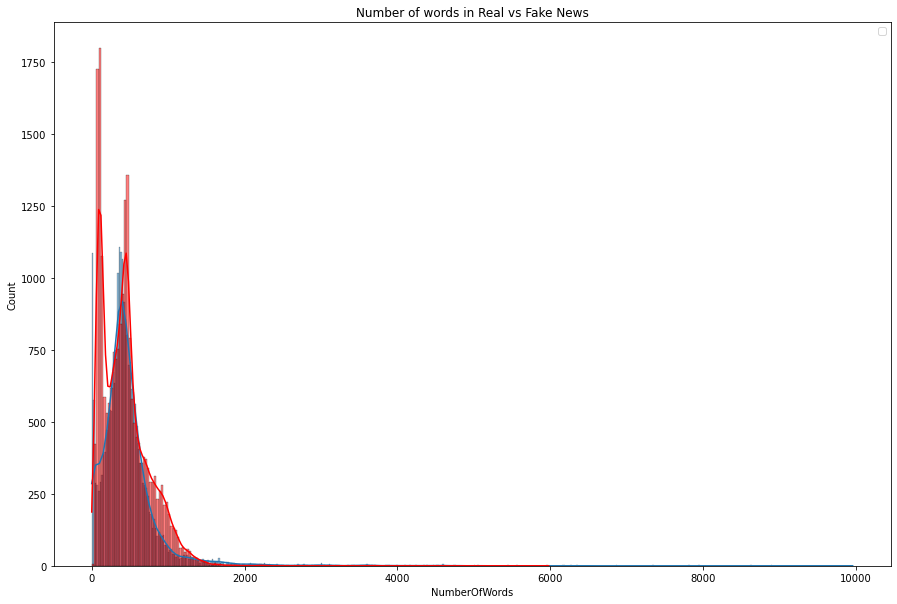

In [46]:
plt.figure(figsize=(15,10))
sns.histplot(data[data['Target']==0]['NumberOfWords'], kde=True, multiple="stack", palette="husl")
sns.histplot(data[data['Target']==1]['NumberOfWords'], color = 'red', kde=True, multiple="stack", palette="husl")
plt.title('Number of words in Real vs Fake News')
plt.legend()

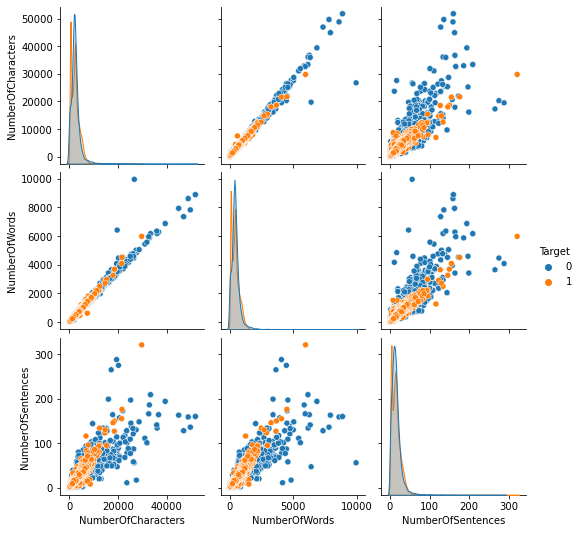

In [47]:
sns.pairplot(data, hue='Target')

Observation: The pairplot above shows that number of words, sentences and characters are bigger and longer in fake news compared to real news

/tmp/ipykernel_11251/699419887.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True)


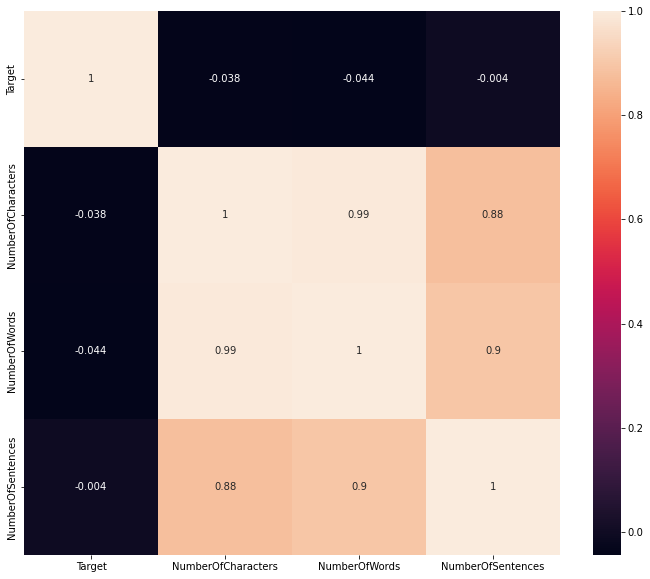

In [48]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(data.corr(), annot=True)
plt.show()

# Data Preprocessing

In [49]:
data.head()

,text,Target,NumberOfCharacters,NumberOfWords,NumberOfSentences
0,Donald Trump just couldn t wish all Americans ...,0,2893,599,28
1,House Intelligence Committee Chairman Devin Nu...,0,1898,331,11
2,"On Friday, it was revealed that former Milwauk...",0,3597,689,25
3,"On Christmas day, Donald Trump announced that ...",0,2774,519,15
4,Pope Francis used his annual Christmas Day mes...,0,2346,458,19


In [50]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jawadkhattak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
ps = PorterStemmer()

In [52]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    
            
    return " ".join(y)

In [53]:
with pd.option_context('display.max_colwidth', None):
    print(data['text'][1])

1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [54]:
transform_text("""House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys  don t help to arrange a New York meeting between Trump and President Abdel Fattah el-Sisi of Egypt two months before the election. It was known before that the former aide set up meetings with world leaders for Trump, but team Trump ran with him being merely a coffee boy.In May 2016, Papadopoulos revealed to Australian diplomat Alexander Downer that Russian officials were shopping around possible dirt on then-Democratic presidential nominee Hillary Clinton. Exactly how much Mr. Papadopoulos said that night at the Kensington Wine Rooms with the Australian, Alexander Downer, is unclear,  the report states.  But two months later, when leaked Democratic emails began appearing online, Australian officials passed the information about Mr. Papadopoulos to their American counterparts, according to four current and former American and foreign officials with direct knowledge of the Australians  role. Papadopoulos pleaded guilty to lying to the F.B.I. and is now a cooperating witness with Special Counsel Robert Mueller s team.This isn t a presidency. It s a badly scripted reality TV show.Photo by Win McNamee/Getty Images.
1    WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administration’s request to put on hold orders by lower court judges requiring the military to begin accepting transgender recruits on Jan. 1. A Justice Department official said the administration will not challenge those rulings. “The Department of Defense has announced that it will be releasing an independent study of these issues in the coming weeks. So rather than litigate this interim appeal before that occurs, the administration has decided to wait for DOD’s study and will continue to defend the president’s lawful authority in District Court in the meantime,” the official said, speaking on condition of anonymity. In September, the Pentagon said it had created a panel of senior officials to study how to implement a directive by Trump to prohibit transgender individuals from serving. The Defense Department has until Feb. 21 to submit a plan to Trump. Lawyers representing currently-serving transgender service members and aspiring recruits said they had expected the administration to appeal the rulings to the conservative-majority Supreme Court, but were hoping that would not happen. Pentagon spokeswoman Heather Babb said in a statement: “As mandated by court order, the Department of Defense is prepared to begin accessing transgender applicants for military service Jan. 1. All applicants must meet all accession standards.” Jennifer Levi, a lawyer with gay, lesbian and transgender advocacy group GLAD, called the decision not to appeal “great news.” “I’m hoping it means the government has come to see that there is no way to justify a ban and that it’s not good for the military or our country,” Levi said. Both GLAD and the American Civil Liberties Union represent plaintiffs in the lawsuits filed against the administration. In a move that appealed to his hard-line conservative supporters, Trump announced in July that he would prohibit transgender people from serving in the military, reversing Democratic President Barack Obama’s policy of accepting them. Trump said on Twitter at the time that the military “cannot be burdened with the tremendous medical costs and disruption that transgender in the military would entail.” Four federal judges - in Baltimore, Washington, D.C., Seattle and Riverside, California - have issued rulings blocking Trump’s ban while legal challenges to the Republican president’s policy proceed. The judges said the ban would likely violate the right under the U.S. Constitution to equal protection under the law. The Pentagon on Dec. 8 issued guidelines to recruitment personnel in order to enlist transgender applicants by Jan. 1. The memo outlined medical requirements and specified how the applicants’ sex would be identified and even which undergarments they would wear. The Trump administration previously said in legal papers that the armed forces were not prepared to train thousands of personnel on the medical standards needed to process transgender applicants and might have to accept “some individuals who are not medically fit for service.” The Obama administration had set a deadline of July 1, 2017, to begin accepting transgender recruits. But Trump’s defense secretary, James Mattis, postponed that date to Jan. 1, 2018, which the president’s ban then put off indefinitely. Trump has taken other steps aimed at rolling back transgender rights. In October, his administration said a federal law banning gender-based workplace discrimination does not protect transgender employees, reversing another Obama-era position. In February, Trump rescinded guidance issued by the Obama administration saying that public schools should allow transgender students to use the restroom that corresponds to their gender identity. """)

'hous intellig committe chairman devin nune go bad day assumpt like mani us christoph prompt russia investig lash depart justic fbi order protect trump happen dossier start investig accord document obtain new york trump campaign advis georg papadopoulo drunk wine bar reveal knowledg russian opposit research hillari top papadopoulo covfef boy trump administr alleg much larger role none damn drunken fool wine bar coffe boy help arrang new york meet trump presid abdel fattah egypt two month elect known former aid set meet world leader trump team trump ran mere coffe may 2016 papadopoulo reveal australian diplomat alexand downer russian offici shop around possibl dirt presidenti nomine hillari clinton exactli much papadopoulo said night kensington wine room australian alexand downer unclear report state two month later leak democrat email began appear onlin australian offici pass inform papadopoulo american counterpart accord four current former american foreign offici direct knowledg aust

In [55]:
data['transform_text'] = data['text'].apply(transform_text)

In [56]:
data.head()

,text,Target,NumberOfCharacters,NumberOfWords,NumberOfSentences,transform_text
0,Donald Trump just couldn t wish all Americans ...,0,2893,599,28,donald trump wish american happi new year leav...
1,House Intelligence Committee Chairman Devin Nu...,0,1898,331,11,hous intellig committe chairman devin nune go ...
2,"On Friday, it was revealed that former Milwauk...",0,3597,689,25,friday reveal former milwauke sheriff david cl...
3,"On Christmas day, Donald Trump announced that ...",0,2774,519,15,christma day donald trump announc would back w...
4,Pope Francis used his annual Christmas Day mes...,0,2346,458,19,pope franci use annual christma day messag reb...


In [57]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

In [58]:
fake_news = wc.generate(data[data['Target'] == 0]['transform_text'].str.cat(sep=" "))

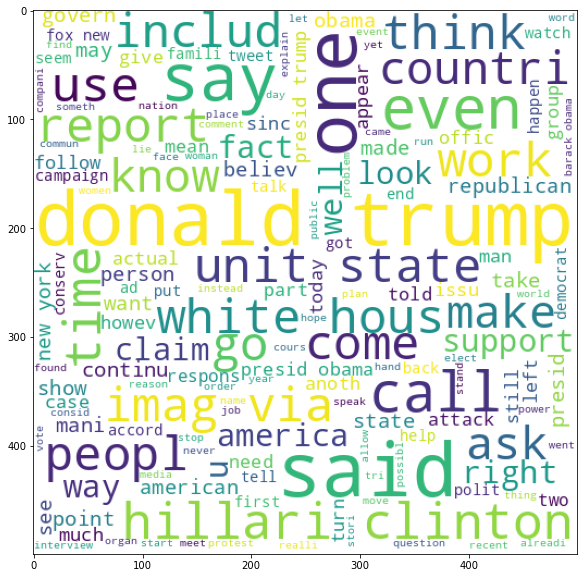

In [59]:
plt.figure(figsize=(15,10))
plt.imshow(fake_news)

In [60]:
True_news = wc.generate(data[data['Target'] == 0]['transform_text'].str.cat(sep=" "))

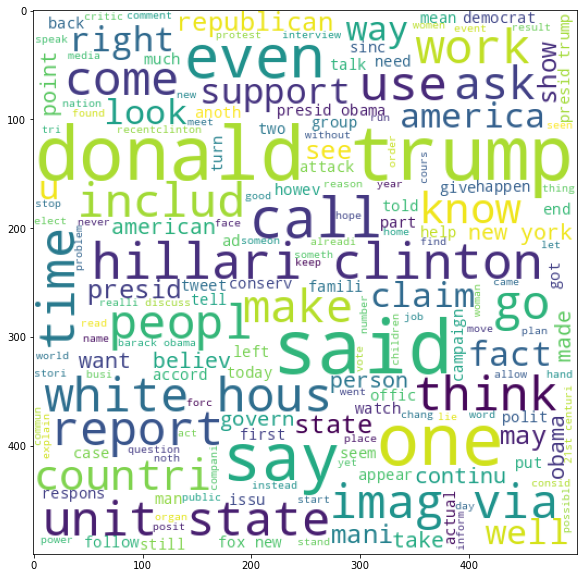

In [61]:
plt.figure(figsize=(15,10))
plt.imshow(True_news)

In [62]:
fake_corpus = []
for msg in data[data['Target'] == 0]['transform_text'].tolist():
    for word in msg.split():
        fake_corpus.append(word)

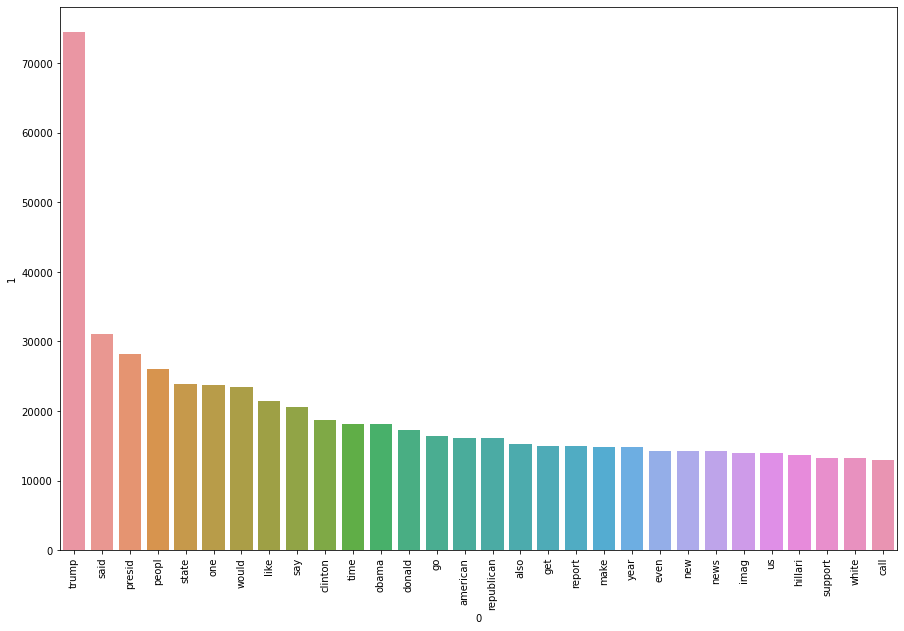

In [63]:
plt.figure(figsize=(15,10))
most_common_words = Counter(fake_corpus).most_common(30)
word_count_df = pd.DataFrame(most_common_words)
sns.barplot(x=word_count_df[0], y=word_count_df[1])
plt.xticks(rotation='vertical')

plt.show()


In [64]:
True_corpus = []
for msg in data[data['Target'] == 1]['transform_text'].tolist():
    for word in msg.split():
        True_corpus.append(word)

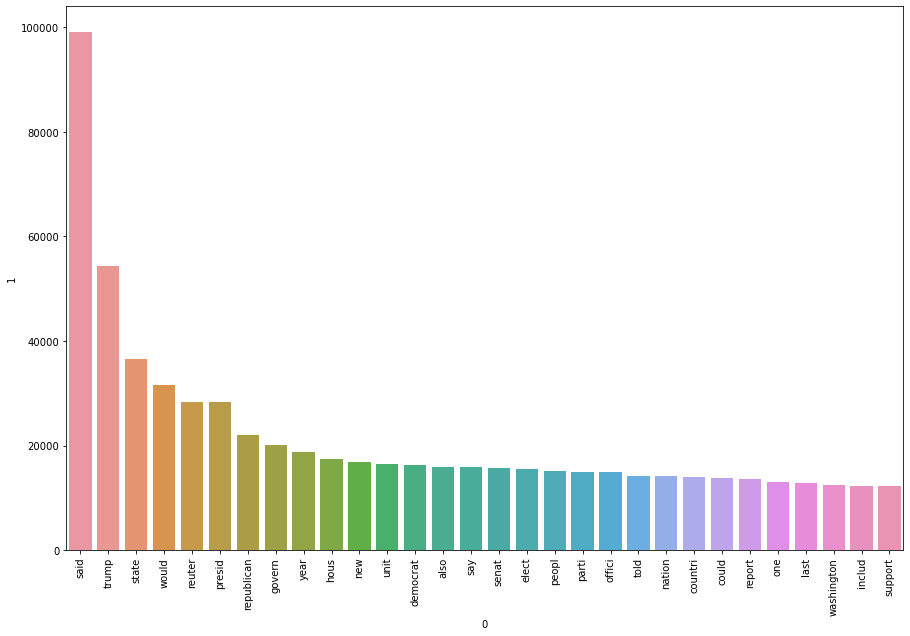

In [65]:
# Set the figure size
plt.figure(figsize=(15,10))

# Use the Counter class to count the occurrences of each word in the True_corpus text corpus, and take the 30 most common words
most_common_words = Counter(True_corpus).most_common(30)

# Convert the list of most common words into a Pandas DataFrame
word_count_df = pd.DataFrame(most_common_words)

# Create a bar plot using Seaborn
sns.barplot(x=word_count_df[0], y=word_count_df[1])

# Rotate the x-axis labels vertically for better readability
plt.xticks(rotation='vertical')

# Show the plot
plt.show()


# Model building

In [66]:

cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

In [67]:
X = tfidf.fit_transform(data['transform_text']).toarray()


In [68]:
y = data['Target'].values

In [69]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [100]:
gnb = GaussianNB()
#mnb = MultinomialNB()
bnb = BernoulliNB()

In [101]:
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.8948657979730482
[[4242  469]
 [ 475 3793]]
0.8899577663068982


In [72]:
# mnb.fit(X_train,y_train)
# y_pred2 = mnb.predict(X_test)
# print(accuracy_score(y_test,y_pred2))
# print(confusion_matrix(y_test,y_pred2))
# print(precision_score(y_test,y_pred2))

0.9188105579685933
[[4354  357]
 [ 372 3896]]
0.9160592522924994


In [102]:
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))
print(precision_score(y_test,y_pred3))

0.9595723354493819
[[4507  204]
 [ 159 4109]]
0.9527011361001623


In [103]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
#mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [104]:
clfs = {
    'SVC' : svc,
    'KN' : knc, 
    #'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [105]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [106]:
train_classifier(svc,X_train,y_train,X_test,y_test)

(0.9876378215836953, 0.9828106852497096)

In [107]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.9876378215836953
Precision -  0.9828106852497096
For  KN
Accuracy -  0.7383895756765787
Precision -  0.8963238331268071
For  DT
Accuracy -  0.9961020158146787
Precision -  0.9932416686087159
For  LR
Accuracy -  0.9930949994431452
Precision -  0.9899813606710158
For  RF
Accuracy -  0.9976612094888072
Precision -  0.9969576410016382
For  AdaBoost
Accuracy -  0.995211048000891
Precision -  0.9929988331388565
For  BgC
Accuracy -  0.9975498385120838
Precision -  0.9974226804123711
For  ETC
Accuracy -  0.9886401603742064
Precision -  0.9844186046511628
For  GBDT
Accuracy -  0.9954337899543378
Precision -  0.99185478240633
For  xgb
Accuracy -  0.9982180643724246
Precision -  0.9978922716627635


In [108]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)

In [109]:
performance_df

,Algorithm,Accuracy,Precision
9,xgb,0.998218,0.997892
6,BgC,0.997550,0.997423
4,RF,0.997661,0.996958
2,DT,0.996102,0.993242
5,AdaBoost,0.995211,0.992999
8,GBDT,0.995434,0.991855
3,LR,0.993095,0.989981
7,ETC,0.988640,0.984419
0,SVC,0.987638,0.982811
1,KN,0.738390,0.896324


In [110]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")

In [111]:
performance_df1

,Algorithm,variable,value
0,xgb,Accuracy,0.998218
1,BgC,Accuracy,0.997550
2,RF,Accuracy,0.997661
3,DT,Accuracy,0.996102
4,AdaBoost,Accuracy,0.995211
5,GBDT,Accuracy,0.995434
6,LR,Accuracy,0.993095
7,ETC,Accuracy,0.988640
8,SVC,Accuracy,0.987638
9,KN,Accuracy,0.738390


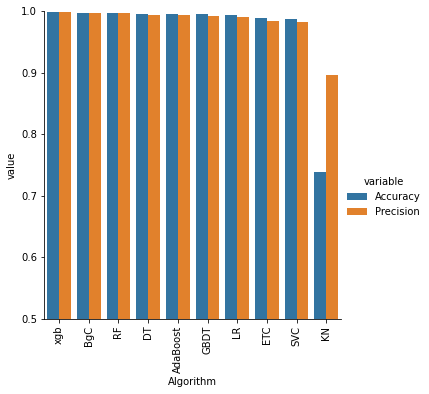

In [112]:
sns.catplot(x = 'Algorithm', y='value', 
               hue = 'variable',data=performance_df1, kind='bar',height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()

In [113]:
temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_max_ft_3000':accuracy_scores,'Precision_max_ft_3000':precision_scores}).sort_values('Precision_max_ft_3000',ascending=False)

In [114]:
temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_scaling':accuracy_scores,'Precision_scaling':precision_scores}).sort_values('Precision_scaling',ascending=False)

In [115]:
new_df = performance_df.merge(temp_df,on='Algorithm')

In [116]:
new_df_scaled = new_df.merge(temp_df,on='Algorithm')

In [117]:
temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_num_chars':accuracy_scores,'Precision_num_chars':precision_scores}).sort_values('Precision_num_chars',ascending=False)

In [118]:
new_df_scaled.merge(temp_df,on='Algorithm')

,Algorithm,Accuracy,Precision,Accuracy_scaling_x,Precision_scaling_x,Accuracy_scaling_y,Precision_scaling_y,Accuracy_num_chars,Precision_num_chars
0,xgb,0.998218,0.997892,0.998218,0.997892,0.998218,0.997892,0.998218,0.997892
1,BgC,0.997550,0.997423,0.997550,0.997423,0.997550,0.997423,0.997550,0.997423
2,RF,0.997661,0.996958,0.997661,0.996958,0.997661,0.996958,0.997661,0.996958
3,DT,0.996102,0.993242,0.996102,0.993242,0.996102,0.993242,0.996102,0.993242
4,AdaBoost,0.995211,0.992999,0.995211,0.992999,0.995211,0.992999,0.995211,0.992999
5,GBDT,0.995434,0.991855,0.995434,0.991855,0.995434,0.991855,0.995434,0.991855
6,LR,0.993095,0.989981,0.993095,0.989981,0.993095,0.989981,0.993095,0.989981
7,ETC,0.988640,0.984419,0.988640,0.984419,0.988640,0.984419,0.988640,0.984419
8,SVC,0.987638,0.982811,0.987638,0.982811,0.987638,0.982811,0.987638,0.982811
9,KN,0.738390,0.896324,0.738390,0.896324,0.738390,0.896324,0.738390,0.896324


In [127]:
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(xgb,open('model.pkl','wb'))